In [1]:
import sys
sys.path.insert(0, '../code/')
sys.path.insert(0, '../data/')
import lcbnn_multiclass as lcbnn
import synthetic
from utils import plot_confusion_matrix
import tensorflow as tf
import numpy as np
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Input, Merge, Reshape
from keras.layers.core import Lambda, Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Settings
plt.rcParams['figure.figsize'] = (13, 13) # Width and height
np.random.seed(seed=0)
random.seed(0)
batch_size = 5
epochs = 150
evaluate = True
training = False

/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Sources:

https://github.com/divamgupta/image-segmentation-keras/blob/master/Models/Segnet.py

https://github.com/0bserver07/Keras-SegNet-Basic/blob/master/model-basic.py


## Import data

In [2]:
num_classes = 12

data_path = '../../loss-cal-BNN/Segnet/'  # This needs to change
# Data

if evaluate == False:
    x_train = np.load( data_path + 'data/train_data.npy')
    x_train = np.moveaxis(x_train,1,-1)
    y_train = np.load(data_path + 'data/train_label.npy')

    x_val = np.load(data_path + 'data/val_data.npy')
    x_val = np.moveaxis(x_val,1,-1)
    y_val = np.load(data_path + 'data/val_label.npy')

else:
    x_test = np.load(data_path + 'data/test_data.npy')
    x_test = np.moveaxis(x_test,1,-1)
    y_test = np.load(data_path + 'data/test_label.npy')


# x_train = x_train[:,1:89,:,:]
# x_test = x_test[:,1:89,:,:]
# x_val = x_val[:,1:89,:,:]

# Moveaxis for theano shape
if evaluate == False:
    x_train = np.moveaxis(x_train[:360],-1,1)
    y_train = y_train[:360]

    x_val = np.moveaxis(x_val[:100],-1,1)
    y_val = y_val[:100]

else:
    x_test = np.moveaxis(x_test[:233],-1,1)
    y_test = y_test[:233]

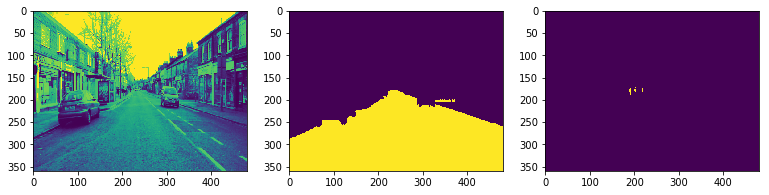

<Figure size 936x936 with 0 Axes>

In [4]:
# Some plot TODO?
if training:
    plt.rcParams['figure.figsize'] = (13, 13) # Width and height
    plt.figure()
    plt.subplot(331)
    plt.imshow(x_train[200,0,:,:])
    plt.subplot(332)
    plt.imshow(y_train.reshape((y_train.shape[0],360,480,num_classes))[200,:,:,3])
    plt.subplot(333)
    plt.imshow(y_train.reshape((y_train.shape[0],360,480,num_classes))[200,:,:,9])
    plt.show()
    plt.clf() # Save memory where possible
else:
    plt.rcParams['figure.figsize'] = (13, 13) # Width and height
    plt.figure()
    plt.subplot(331)
    plt.imshow(x_test[200,0,:,:])
    plt.subplot(332)
    plt.imshow(y_test.reshape((y_test.shape[0],360,480,num_classes))[200,:,:,3])
    plt.subplot(333)
    plt.imshow(y_test.reshape((y_test.shape[0],360,480,num_classes))[200,:,:,9])
    plt.show()
    plt.clf() # Save memory where possible

## Set up utility

In [5]:
I = np.eye(num_classes)
object_name = ['Sky', 'Building', 'Pole', 'Road', 'Pavement',
 'Tree', 'SignSymbol', 'Fence', 'Car', 'Pedestrian','Cyclist','Unlabelled']

digits_lower_loss = [8,9,10]
sky = [0]
building = [1]

L = np.copy(I)
L[np.where(I==0)] = 0.6
L[digits_lower_loss] = 0.4 # Select more important rows with lower loss in prediction
L[sky] = 0.8
L[building] = 0.8

# Fill columns:
# L[:,digits_lower_loss] = 1.0
L[np.flip(digits_lower_loss[1:],0),digits_lower_loss[1:]] = 0

L[np.where(I==1)] = 0

loss_mat = L
M = 0.80001

print("         TRUTH\n" )
string = 'PRED'
for i in range(num_classes):
    if i < 4:
        print(string[i],'  ',object_name[i],': ',loss_mat[i])
    else:
        print('    ',object_name[i],': ',loss_mat[i])
        
# Set up weight for weighted cross entropy
# Maximise
factor = 10.

class_weight = np.ones((num_classes))
class_weight[digits_lower_loss] = (1./0.2) * factor
class_weight[sky] = (1./0.8) * factor
class_weight[building] = 1./1. * factor

         TRUTH

P    Sky :  [0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
R    Building :  [0.8 0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
E    Pole :  [0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
D    Road :  [0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
     Pavement :  [0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6 0.6]
     Tree :  [0.6 0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6 0.6]
     SignSymbol :  [0.6 0.6 0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6 0.6]
     Fence :  [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.  0.6 0.6 0.6 0.6]
     Car :  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.  0.4 0.4 0.4]
     Pedestrian :  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.  0.  0.4]
     Cyclist :  [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.  0.  0.4]
     Unlabelled :  [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0. ]


## Time to integrate through training images (360)

In [5]:
y_pred_samples = np.expand_dims(y_train,0)
y_all = y_pred_samples.reshape((1,360*172800,12))

import time
t0 = time.time()
H_x = []
h_x = lcbnn.optimal_h(y_all,loss_mat) #np.random.randint(0,2,(np.shape(y_train)))
print('%.2f seconds' % (time.time()-t0))

44.19 seconds


## Check optimal label is working by applying to training data 

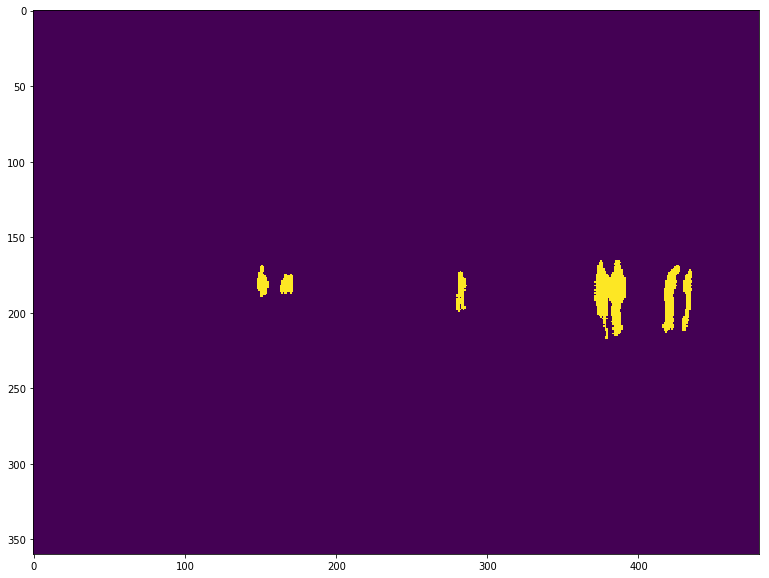

<Figure size 936x936 with 0 Axes>

In [6]:
plt.figure()
plt.imshow(h_x.reshape((360,360,480,num_classes))[200,:,:,9])
plt.show()
plt.clf() # Save memory where possible

## General network structure

In [10]:
dropout = 0.5 # as in paper
# Regularise
# tau = 1.0
# lengthscale = .01
# reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

# Legacy theano
K.set_image_dim_ordering('th')

def segnet(nClasses , optimizer=None , input_height=360, input_width=480 ):

    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    model = Sequential()
    model.add(Layer(input_shape=(3, input_height , input_width )))

    # encoder
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added
    
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added
    
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added

    # decoder
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(512, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())
    model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added

    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(256, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())

    model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(128, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())
    
#     model.add(Lambda(lambda x: K.dropout(x,level=dropout))) # Added
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
    model.add( BatchNormalization())


    model.add(Convolution2D( nClasses , 1, 1, border_mode='valid',))

    model.outputHeight = model.output_shape[-2]
    model.outputWidth = model.output_shape[-1]


    model.add(Reshape(( nClasses ,  model.output_shape[-2]*model.output_shape[-1]   ), input_shape=( nClasses , model.output_shape[-2], model.output_shape[-1]  )))

    model.add(Permute((2, 1)))
    model.add(Activation('softmax'))

    if not optimizer is None:
        model.compile(loss="categorical_crossentropy", optimizer= optimizer , metrics=['accuracy'] )

    return model

In [12]:
epoch10_std = '../models/segnet/segnet_std_dropout_10epoch.h5'

### Standard

In [13]:
weights_file_std = '../models/segnet/exp4_150_epoch/segnet_std_dropout_100.h5'
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10, monitor='val_loss')
# csv_logger = CSVLogger('model_weights/segnet-basic-12c.csv')
model_checkpoint = ModelCheckpoint(weights_file_std, monitor='val_loss', save_best_only=True,
                                   save_weights_only=True, mode='auto')

std_model = segnet(nClasses = num_classes)
std_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

std_model.load_weights(epoch10_std)
if training == True:
    history_std = std_model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=[x_val,y_val],
                      callbacks=[lr_reducer, early_stopper, model_checkpoint],
                      shuffle=True)
std_model.load_weights(weights_file_std) 

/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/l

In [14]:
# import pickle
# pickle.dump(history_std.history,open("../models/segnet/exp4_150_epoch/history_std_56_10init_epochs.p","wb"))

### Weighted

In [15]:
weights_file_we = '../models/segnet/exp4_150_epoch/segnet_we_dropout_100.h5'
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10, monitor='val_loss')
# csv_logger = CSVLogger('model_weights/segnet-basic-12c.csv')
model_checkpoint = ModelCheckpoint(weights_file_we, monitor='val_loss', save_best_only=True,
                                   save_weights_only=True, mode='auto')

we_model = segnet(nClasses = num_classes)
we_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
we_model.load_weights(epoch10_std)
if training == True:
    history_we = we_model.fit(x_train, y_train,
                      class_weight = class_weight,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=[x_val,y_val],
                      callbacks=[lr_reducer, early_stopper, model_checkpoint],
                      shuffle=True)
we_model.load_weights(weights_file_we)  

/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/l

In [16]:
# pickle.dump(history_we.history,open("../models/segnet/exp4_150_epoch/history_we_66_10init_epochs.p","wb"))

### Loss-calibrated

In [17]:
N_tr = 360
N_val = 100
height = 360
width = 480

weights_file_lc = '../models/segnet/exp4_150_epoch/segnet_lc_dropout_150.h5'
lr_reducer = ReduceLROnPlateau(monitor='val_loss',factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10, monitor='val_loss')
# csv_logger = CSVLogger('model_weights/segnet-basic-12c.csv')
model_checkpoint = ModelCheckpoint(weights_file_lc, monitor='val_loss', save_best_only=True,
                                   save_weights_only=True, mode='auto')

M_tf = tf.constant(M, dtype=tf.float32)
basic_model = segnet(nClasses = num_classes)
# Initilise loss
loss = lcbnn.loss_K(loss_mat,Segmentation=True)

H_x = Input(shape=(height*width,num_classes),name='H_x')
y_true = Input(shape=(height*width,num_classes),name='y_true')
x = Input(shape=(3, height , width ),name='x')

# load pretrained weights
basic_model.load_weights(epoch10_std)

y_pred = basic_model(x)

lc_model = Model([x,H_x],y_pred)

# lc_model_reshape_output = Model([x,H_x],y_pred_r)

lc_model.compile(loss = lcbnn.cal_loss(loss,M,H_x,Segmentation=True),optimizer='adam')

#Initiailisations:

if evaluate==False:
    y_pred_samples = np.expand_dims(y_train,0).reshape((1,N_tr*height*width,num_classes))
    y_pred_samples_val = np.expand_dims(y_val,0).reshape((1,N_val*height*width,num_classes))

    H_x = lcbnn.optimal_h(y_pred_samples,loss_mat).reshape((N_tr,height*width,num_classes)) #np.random.randint(0,2,(np.shape(y_train)))
    H_x_val = lcbnn.optimal_h(y_pred_samples_val,loss_mat).reshape((N_val,height*width,num_classes))

    del y_pred_samples
    del y_pred_samples_val
# lc_model.load_weights(epoch10_std)
if training == True:
    history_lc = []
    for epoch in range(epochs):
        h_lc = lc_model.fit([x_train,H_x],[y_train],
                     batch_size=batch_size,
                     nb_epoch=1,
                     verbose=2,
                     validation_data=[[x_val,H_x_val],y_val],
                     callbacks=[lr_reducer, early_stopper, model_checkpoint],
                     shuffle=True)
        T = 5
        yt_hat = np.array([lc_model.predict([x_train,H_x],batch_size=batch_size) for _ in range(T)])
        yt_hat = yt_hat.reshape((T,N_tr*height*width,num_classes))
        H_x = lcbnn.optimal_h(yt_hat,loss_mat).reshape((N_tr,height*width,num_classes))
        del yt_hat
        history_lc.append(h_lc)
        if epoch % 10 ==1:
            print('Epoch: ',epoch)
        
lc_model.load_weights(weights_file_lc) 

/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/home/ikiskin/anaconda3/envs/tensorflow/l

## Results

In [19]:
N_te = 233

# weights_file_we = '../models/segnet/exp2_100_epoch/segnet_we_dropout_100.h5'
# we_model.load_weights(weights_file_we)

# weights_file_std = '../models/segnet/exp2_100_epoch/segnet_std_dropout_100.h5'
# std_model.load_weights(weights_file_std)

# weights_file_lc = '../models/segnet/exp2_100_epoch/segnet_lc_dropout_100.h5'
# lc_model.load_weights(weights_file_lc)

T = 10
H_x_test = np.zeros_like(y_test)

#######
# STD #
#######
yt_hat_std = np.array([std_model.predict([x_test]) for _ in range(T)]).reshape((T,N_te*height*width,num_classes))
MC_pred_std = np.mean(yt_hat_std, 0)
H_x_test_std = lcbnn.optimal_h(yt_hat_std,loss_mat).reshape((N_te,height*width,num_classes)) 
acc_std = accuracy_score(np.argmax(y_test.reshape((N_te*height*width,num_classes)),1),np.argmax(H_x_test_std.reshape((N_te*height*width,num_classes)),1))
loss_std = np.mean(lcbnn.loss_np(y_test.reshape((N_te*height*width,num_classes)),H_x_test_std.reshape((N_te*height*width,num_classes)),loss_mat))
acc_o_std = accuracy_score(np.argmax(y_test.reshape((N_te*height*width,num_classes)),1),np.argmax(MC_pred_std.reshape((N_te*height*width,num_classes)),1))
loss_o_std = np.mean(lcbnn.loss_np(y_test.reshape((N_te*height*width,num_classes)),MC_pred_std.reshape((N_te*height*width,num_classes)),loss_mat))

print('Standard:\n')
print('Accuracy on NN output: ', acc_o_std)
print('Expected loss on NN output: ', loss_o_std)
print('Accuracy on optimal decision: ', acc_std)
print('Expected loss: ', loss_std)

del yt_hat_std

#######
# WEI #
#######
yt_hat_we = np.array([we_model.predict([x_test]) for _ in range(T)]).reshape((T,N_te*height*width,num_classes))
MC_pred_we = np.mean(yt_hat_we, 0)
H_x_test_we = lcbnn.optimal_h(yt_hat_we,loss_mat).reshape((N_te,height*width,num_classes)) 
acc_we = accuracy_score(np.argmax(y_test.reshape((N_te*height*width,num_classes)),1),np.argmax(H_x_test_we.reshape((N_te*height*width,num_classes)),1))
loss_we = np.mean(lcbnn.loss_np(y_test.reshape((N_te*height*width,num_classes)),H_x_test_we.reshape((N_te*height*width,num_classes)),loss_mat))
acc_o_we = accuracy_score(np.argmax(y_test.reshape((N_te*height*width,num_classes)),1),np.argmax(MC_pred_we.reshape((N_te*height*width,num_classes)),1))
loss_o_we = np.mean(lcbnn.loss_np(y_test.reshape((N_te*height*width,num_classes)),MC_pred_we.reshape((N_te*height*width,num_classes)),loss_mat))

print('\nWeighted:\n')
print('Accuracy on NN output: ', acc_o_we)
print('Expected loss on NN output: ', loss_o_we)
print('Accuracy on optimal decision: ', acc_we)
print('Expected loss: ', loss_we)

del yt_hat_we

#######
# L-C #
#######
yt_hat_lc = np.array([lc_model.predict([x_test, H_x_test]) for _ in range(T)]).reshape((T,N_te*height*width,num_classes))
MC_pred_lc = np.mean(yt_hat_lc, 0)
H_x_test_lc = lcbnn.optimal_h(yt_hat_lc,loss_mat).reshape((N_te,height*width,num_classes)) 
acc_lc = accuracy_score(np.argmax(y_test.reshape((N_te*height*width,num_classes)),1),np.argmax(H_x_test_lc.reshape((N_te*height*width,num_classes)),1))
loss_lc = np.mean(lcbnn.loss_np(y_test.reshape((N_te*height*width,num_classes)),H_x_test_lc.reshape((N_te*height*width,num_classes)),loss_mat))
acc_o_lc = accuracy_score(np.argmax(y_test.reshape((N_te*height*width,num_classes)),1),np.argmax(MC_pred_lc.reshape((N_te*height*width,num_classes)),1))
loss_o_lc = np.mean(lcbnn.loss_np(y_test.reshape((N_te*height*width,num_classes)),MC_pred_lc.reshape((N_te*height*width,num_classes)),loss_mat))

print('\nLoss-cal:\n')
print('Accuracy on NN output: ', acc_o_lc)
print('Expected loss on NN output: ', loss_o_lc)
print('Accuracy on optimal decision: ', acc_lc)
print('Expected loss: ', loss_lc)

del yt_hat_lc

Standard:

Accuracy on NN output:  0.8110268886107137
Expected loss on NN output:  0.18080523495948947
Accuracy on optimal decision:  0.780795730011127
Expected loss:  0.12395307780956977

Weighted:

Accuracy on NN output:  0.8207244227865205
Expected loss on NN output:  0.16671536581579727
Accuracy on optimal decision:  0.7960582329915753
Expected loss:  0.11780022055317135

Loss-cal:

Accuracy on NN output:  0.8245817437609283
Expected loss on NN output:  0.1480835944305391
Accuracy on optimal decision:  0.8182758355189954
Expected loss:  0.1154774032347802


In [20]:
print('Standard:\n')
print('Accuracy on NN output: ', acc_o_std)
print('Expected util on NN output: ', M - loss_o_std)
print('Accuracy on optimal decision: ', acc_std)
print('Expected util: ', M - loss_std)

print('\nWeighted:\n')
print('Accuracy on NN output: ', acc_o_we)
print('Expected util on NN output: ', M - loss_o_we)
print('Accuracy on optimal decision: ', acc_we)
print('Expected util: ', M - loss_we)

print('\nLoss-cal:\n')
print('Accuracy on NN output: ', acc_o_lc)
print('Expected util on NN output: ', M - loss_o_lc)
print('Accuracy on optimal decision: ', acc_lc)
print('Expected util: ', M - loss_lc)


Standard:

Accuracy on NN output:  0.8110268886107137
Expected util on NN output:  0.6192047650405106
Accuracy on optimal decision:  0.780795730011127
Expected util:  0.6760569221904302

Weighted:

Accuracy on NN output:  0.8207244227865205
Expected util on NN output:  0.6332946341842027
Accuracy on optimal decision:  0.7960582329915753
Expected util:  0.6822097794468287

Loss-cal:

Accuracy on NN output:  0.8245817437609283
Expected util on NN output:  0.6519264055694609
Accuracy on optimal decision:  0.8182758355189954
Expected util:  0.6845325967652198


# Visualise

In [96]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road_marking = [255,69,0]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
                          Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def visualize(temp, plot=True, one_hot=True):
    if one_hot:
        temp = np.argmax(temp,-1)
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,12):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb,aspect="auto")
        plt.xticks([])
        plt.yticks([])
    else:
        return rgb

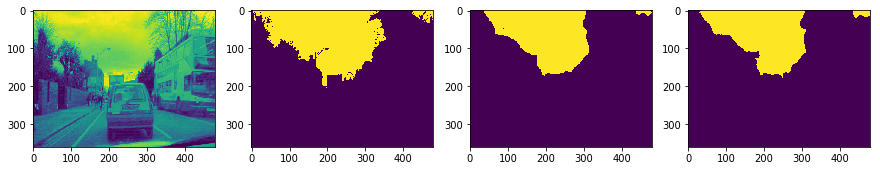

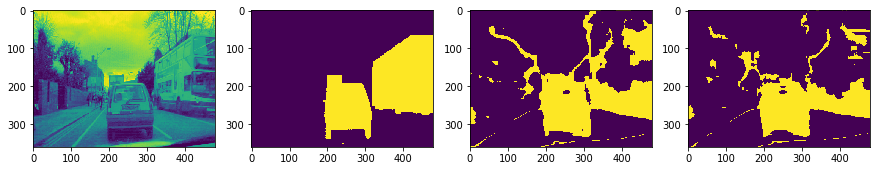

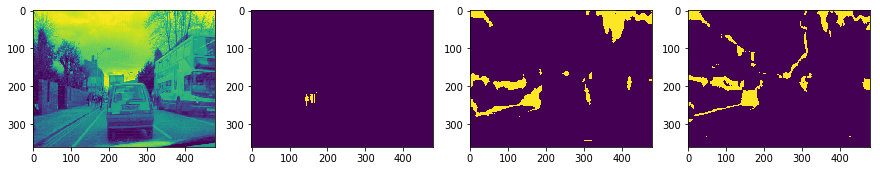

In [97]:
plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,0])
plt.subplot(443)
plt.imshow(H_x_test_std.reshape((6,360,480,num_classes))[0,:,:,0])
plt.subplot(444)
plt.imshow(H_x_test_lc.reshape((6,360,480,num_classes))[0,:,:,0])


plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,8])
plt.subplot(443)
plt.imshow(H_x_test_std.reshape((6,360,480,num_classes))[0,:,:,8])
plt.subplot(444)
plt.imshow(H_x_test_lc.reshape((6,360,480,num_classes))[0,:,:,8])

plt.figure()
plt.subplot(441)
plt.imshow(test_images[0,2,:,:])
plt.subplot(442)
plt.imshow(test_labels.reshape((6,360,480,num_classes))[0,:,:,9])
plt.subplot(443)
plt.imshow(H_x_test_std.reshape((6,360,480,num_classes))[0,:,:,9])
plt.subplot(444)
plt.imshow(H_x_test_lc.reshape((6,360,480,num_classes))[0,:,:,9])

## Plot confusion matrices:

Normalized confusion matrix
[[8.70e-01 3.40e-02 4.25e-04 6.41e-04 8.12e-05 6.54e-02 8.00e-06 1.46e-07
  9.61e-03 1.79e-02 0.00e+00 1.48e-03]
 [5.56e-03 7.61e-01 1.31e-04 3.56e-03 2.15e-02 4.11e-02 8.18e-03 5.37e-03
  5.74e-02 9.21e-02 0.00e+00 3.68e-03]
 [9.31e-02 3.82e-01 4.54e-03 1.59e-03 6.09e-02 1.31e-01 2.87e-03 7.59e-03
  5.57e-02 2.54e-01 0.00e+00 6.59e-03]
 [1.35e-04 2.73e-03 0.00e+00 9.38e-01 2.68e-02 7.37e-04 0.00e+00 1.72e-05
  2.75e-02 2.70e-03 0.00e+00 1.56e-03]
 [8.04e-07 1.51e-02 5.90e-06 1.91e-01 7.67e-01 3.22e-04 8.04e-07 1.81e-04
  1.02e-02 1.62e-02 0.00e+00 1.71e-04]
 [2.66e-02 9.38e-02 1.06e-04 1.25e-03 1.51e-03 7.73e-01 3.99e-04 5.80e-03
  2.42e-02 6.66e-02 0.00e+00 7.21e-03]
 [1.18e-02 5.33e-01 1.35e-03 1.57e-04 5.66e-04 5.68e-02 7.31e-02 3.54e-04
  9.53e-02 2.23e-01 0.00e+00 4.90e-03]
 [2.27e-04 2.88e-01 1.68e-05 8.62e-03 7.40e-02 6.95e-02 1.36e-04 1.75e-01
  1.40e-01 2.36e-01 0.00e+00 8.51e-03]
 [8.57e-04 1.32e-01 0.00e+00 8.89e-02 6.40e-03 4.73e-03 1.98e-04 1.1

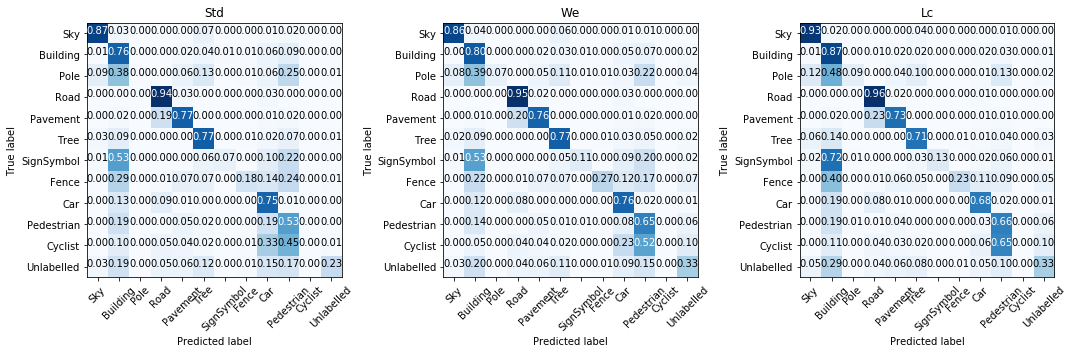

In [11]:
plt.rcParams['figure.figsize'] = (15, 15) # Width and height

classes = object_name

H_std = np.argmax(H_x_test_std.reshape((N_te*height*width,num_classes)), axis=1)
H_we = np.argmax(H_x_test_we.reshape((N_te*height*width,num_classes)), axis=1)
H_lc = np.argmax(H_x_test_lc.reshape((N_te*height*width,num_classes)), axis=1)
Y = np.argmax(y_test.reshape((N_te*height*width,num_classes)), axis=1)

cnf_matrix_std = confusion_matrix(Y.reshape((Y.shape[0],)).astype('float'),np.round(H_std.reshape((H_std.shape[0],))))
np.set_printoptions(precision=2)
cnf_matrix_we = confusion_matrix(Y.reshape((Y.shape[0],)).astype('float'),np.round(H_we.reshape((H_we.shape[0],))))
np.set_printoptions(precision=2)
cnf_matrix_lc = confusion_matrix(Y.reshape((Y.shape[0],)).astype('float'),np.round(H_lc.reshape((H_lc.shape[0],))))
np.set_printoptions(precision=2)


plt.subplot(131)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_std, classes=classes, normalize=True,
                      title='Std')

plt.subplot(132)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_we, classes=classes, normalize=True,
                      title='We')
plt.subplot(133)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_lc, classes=classes, normalize=True,
                      title='Lc')
plt.show()

Normalized confusion matrix
[[8.97e-01 4.49e-02 3.34e-04 5.91e-04 7.25e-05 5.44e-02 2.88e-05 2.04e-06
  8.14e-05 0.00e+00 0.00e+00 2.42e-03]
 [7.53e-03 8.77e-01 6.62e-04 4.86e-03 2.34e-02 4.27e-02 8.11e-03 1.07e-02
  1.08e-02 1.06e-03 2.53e-05 1.35e-02]
 [1.13e-01 5.43e-01 2.16e-02 2.99e-03 9.25e-02 1.43e-01 5.09e-03 3.12e-02
  8.76e-03 1.22e-02 5.72e-04 2.59e-02]
 [2.92e-04 7.39e-03 1.74e-04 9.48e-01 2.80e-02 9.84e-04 2.12e-06 1.15e-04
  1.05e-02 1.10e-04 1.63e-05 4.27e-03]
 [1.08e-04 2.91e-02 5.17e-04 1.94e-01 7.70e-01 5.40e-04 5.09e-06 9.88e-04
  2.55e-03 3.93e-04 5.90e-05 1.96e-03]
 [4.40e-02 1.53e-01 2.46e-04 1.55e-03 2.03e-03 7.69e-01 8.73e-04 1.14e-02
  1.64e-03 3.26e-04 1.77e-06 1.64e-02]
 [1.56e-02 7.65e-01 3.18e-03 3.62e-04 6.54e-04 6.70e-02 1.12e-01 1.59e-03
  1.11e-02 2.42e-03 0.00e+00 2.10e-02]
 [5.16e-04 4.98e-01 8.96e-04 1.35e-02 8.95e-02 8.80e-02 5.87e-04 2.19e-01
  3.50e-02 2.44e-03 1.59e-04 5.23e-02]
 [1.32e-03 2.31e-01 2.31e-05 1.19e-01 1.09e-02 5.44e-03 4.83e-04 1.1

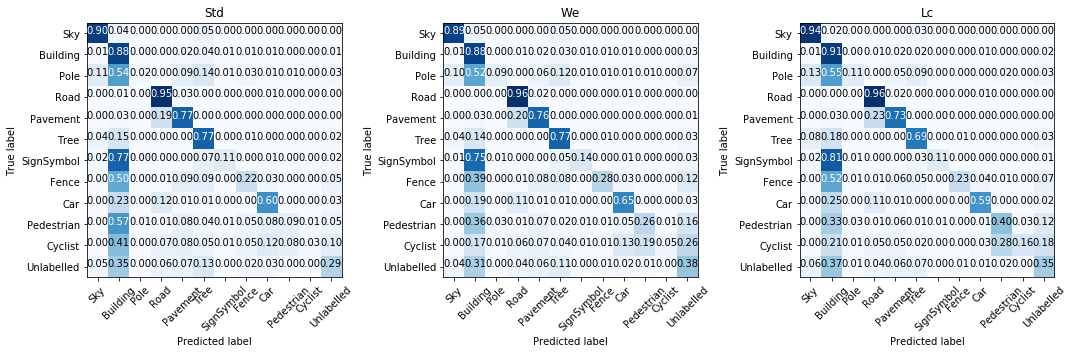

In [12]:
plt.rcParams['figure.figsize'] = (15, 15) # Width and height

classes = object_name

M_std = np.argmax(MC_pred_std.reshape((N_te*height*width,num_classes)), axis=1)
M_we = np.argmax(MC_pred_we.reshape((N_te*height*width,num_classes)), axis=1)
M_lc = np.argmax(MC_pred_lc.reshape((N_te*height*width,num_classes)), axis=1)
# Y = np.argmax(y_test.reshape((N_te*height*width,num_classes)), axis=1)

cnf_matrix_std = confusion_matrix(Y.reshape((Y.shape[0],)).astype('float'),np.round(M_std.reshape((H_std.shape[0],))))
np.set_printoptions(precision=2)
cnf_matrix_we = confusion_matrix(Y.reshape((Y.shape[0],)).astype('float'),np.round(M_we.reshape((H_we.shape[0],))))
np.set_printoptions(precision=2)
cnf_matrix_lc = confusion_matrix(Y.reshape((Y.shape[0],)).astype('float'),np.round(M_lc.reshape((H_lc.shape[0],))))
np.set_printoptions(precision=2)


plt.subplot(131)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_std, classes=classes, normalize=True,
                      title='Std')

plt.subplot(132)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_we, classes=classes, normalize=True,
                      title='We')
plt.subplot(133)
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix_lc, classes=classes, normalize=True,
                      title='Lc')
plt.show()

## IOU

In [24]:
def iou_single_mask(ground_truth,prediction):
    """
    ground_truth: (height,width)
    """
#     area_ground = np.sum(np.sum(ground_truth,-1),-1)
#     area_pred = np.sum(np.sum(prediction,-1),-1)
#     ground_truth + prediction
    intersection = prediction[np.where((ground_truth + prediction)==2)].shape[0]
    union = prediction[np.where((ground_truth + prediction)==1)].shape[0] + intersection
    return intersection/np.maximum(union,1e-7)

def iou_multiple_images_single_mask(ground_truth,prediction):
    """
    ground_truth: (N,height,width)
    """
    N = ground_truth.shape[0]
    iou = np.zeros((ground_truth.shape[0],))
    for n in range(N):
        if np.sum(ground_truth[n]) > 0: 
            iou[n] = iou_single_mask(ground_truth[n],prediction[n])
        else:
            iou[n] = 0
    return iou

def iou_multiple_images_multiple_masks(ground_truth,prediction):
    """
    ground_truth: (N,height,width,classes)
    """
    N = ground_truth.shape[0]
    Masks = ground_truth.shape[3]
    iou = np.zeros((Masks,N))
    for m in range(Masks):
        iou[m] = iou_multiple_images_single_mask(ground_truth[:,:,:,m],prediction[:,:,:,m])
    return iou

def MIOU(IOU):
    """
    remove zeros before taking mean
    IOU = (n_classes, N)
    
    return mIOU: (n_classes,)
    """
    num_classes = np.shape(IOU)[0]
    N_te = np.shape(IOU)[1]
    iou_mean = np.zeros((num_classes,))
    for c in range(num_classes):
        k = 0
        for n in range(N_te):
            if IOU[c,n] > 0:
                iou_mean[c] += IOU[c,n]
                k+=1
        iou_mean[c] /= k
    return iou_mean

[0.82441 0.59839 0.00521 0.85063 0.65071 0.52159 0.04864 0.03524 0.27058
 0.05875 0.      0.15167]
[0.85016 0.66043 0.05861 0.86348 0.64735 0.5195  0.09501 0.04385 0.37271
 0.12264 0.      0.18625]


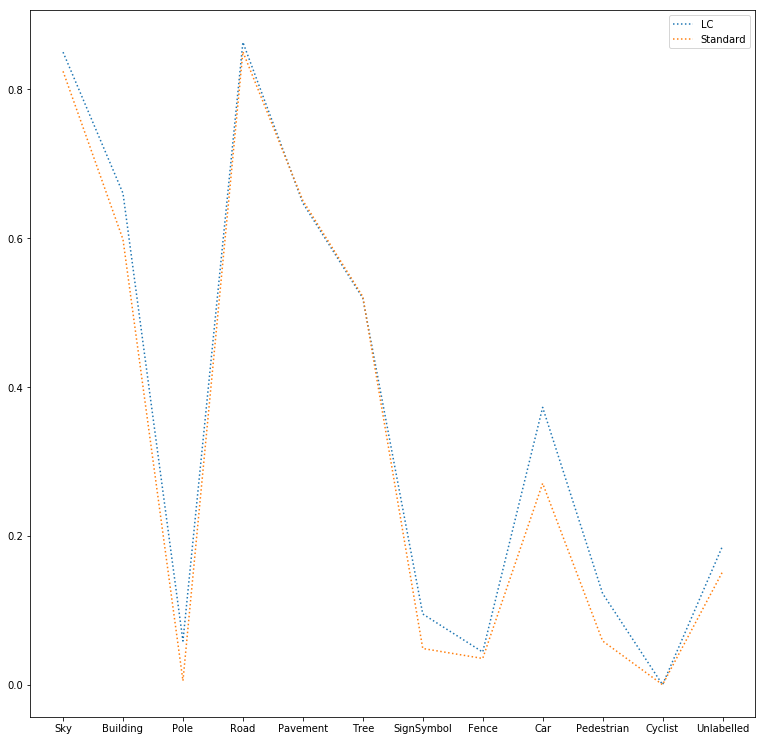

In [25]:
ground_truth = y_test.astype(dtype=np.uint8)[:,:,:].reshape((N_te,height,width,num_classes))
prediction_lc = H_x_test_lc.astype(dtype=np.uint8)[:,:,:].reshape((N_te,height,width,num_classes))
prediction_std = H_x_test_std.astype(dtype=np.uint8)[:,:,:].reshape((N_te,height,width,num_classes))
prediction_we = H_x_test_we.astype(dtype=np.uint8)[:,:,:].reshape((N_te,height,width,num_classes))
IOU_lc = iou_multiple_images_multiple_masks(ground_truth,prediction_lc)
IOU_std = iou_multiple_images_multiple_masks(ground_truth,prediction_std)
# IOU.shape
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

print(IOU_std.mean(-1))
print(IOU_lc.mean(-1))

ax = plt.figure()
plt.plot(IOU_lc.mean(-1),':',label='LC')
plt.plot(IOU_std.mean(-1),':',label='Standard')
tick_marks = np.arange(len(object_name))
plt.xticks(tick_marks, object_name)
plt.legend()
plt.show()

## Training statistics

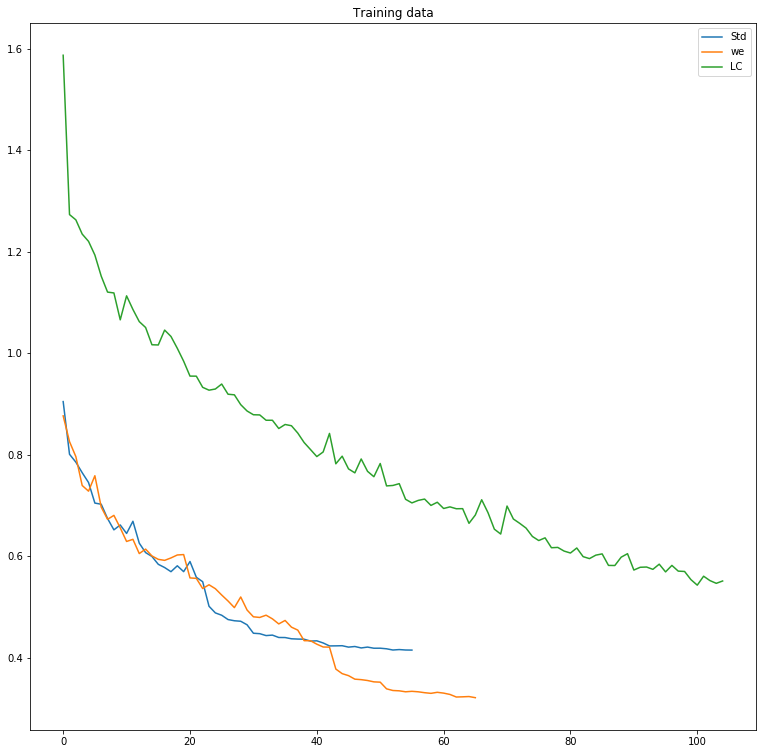

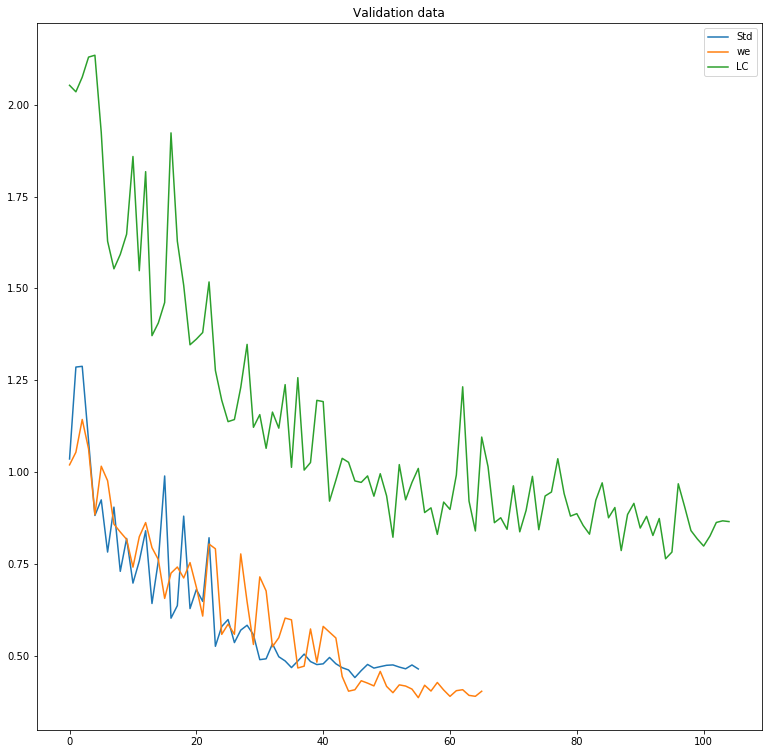

In [19]:
h = []
h_val = []
for i in range(epoch):
    h.append(history_lc[i].history['loss'])
    h_val.append(history_lc[i].history['val_loss'])

# pickle.dump(h,open("history_lc_training_100_10init_epochs.p","wb"))
# pickle.dump(h_val,open("history_lc_val_100_10init_epochs.p","wb"))
history_we = pickle.load(open("../models/segnet/exp4_150_epoch/history_we_66_10init_epochs.p","rb"))
history_std = pickle.load(open("../models/segnet/exp4_150_epoch/history_std_56_10init_epochs.p","rb"))

plt.figure()
plt.title('Training data')
# plt.plot(history_std.history['loss'], label='Std')
plt.plot(history_std['loss'], label='Std')
plt.plot(history_we['loss'], label='we')
# plt.plot(history_we.history['loss'], label='We')
plt.plot(h,label='LC')
plt.legend()
plt.show()

plt.figure()
plt.title('Validation data')
# plt.plot(history_std.history['val_loss'], label='Std')
# plt.plot(history_we.history['val_loss'], label='We')
plt.plot(history_std['val_loss'], label='Std')
plt.plot(history_we['val_loss'], label='we')
plt.plot(h_val,label='LC')
plt.legend()
plt.show()

